### Imports

In [1]:
import os
import tensorflow as tf
import numpy as np
import gzip

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split

### Data Preparation

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [3]:
train_data = extract_data('dataset/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('dataset/t10k-images-idx3-ubyte.gz', 10000)

In [4]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [5]:
train_labels = extract_labels('dataset/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('dataset/t10k-labels-idx1-ubyte.gz',10000)

In [6]:
print(train_data.shape)
print(test_data.shape)

(60000, 28, 28)
(10000, 28, 28)


In [7]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: F)')

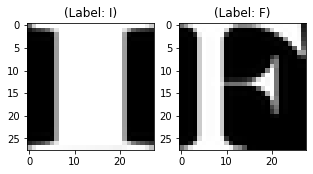

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[1], (28,28))
curr_lbl = train_labels[1]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[1], (28,28))
curr_lbl = test_labels[1]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [9]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)

In [10]:
train_data /= np.max(train_data)
test_data /= np.max(test_data)

In [11]:
train_x,valid_x,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

### Adding noise to the input data

In [53]:
noise_factor = 0.5
x_train_noisy = train_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_x.shape)
x_valid_noisy = valid_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_x.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)

In [54]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)  # bringing pixel value between 0 and 1
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [55]:
print(x_train_noisy.shape)

(48000, 28, 28, 1)


### Visualizing The noisy images

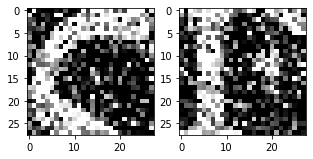

In [56]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

### network

In [57]:
batch_size = 128
epochs = 20
n_channel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, n_channel))

#### Encoder

In [58]:
def encoder(input_image):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    
    return conv3


#### Decoder

In [59]:
def decoder(enc_out):
    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(enc_out)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    
    return decoded

In [60]:
def autoencoder():
    enc = encoder(input_img)
    dec = decoder(enc)
    
    model = Model(inputs=input_img, outputs=dec)
    return model
    

In [61]:
model = autoencoder()

In [62]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 128)         1475

In [63]:
model.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy'])

In [64]:
#model.fit(x_train_noisy, train_x, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_x))

In [65]:
model.load_weights("weights/denoising_autoencoder.h5")

In [66]:
preds = model.predict(x_test_noisy)

In [67]:
encoded_model = Model(inputs=model.input, outputs=model.get_layer('conv2d_14').output)

In [68]:
encoded_preds = encoded_model.predict(x_test_noisy)
encoded_preds = encoded_preds.reshape(len(x_test_noisy), 7*7*128)

#### Test Data

Test Images Without Noise


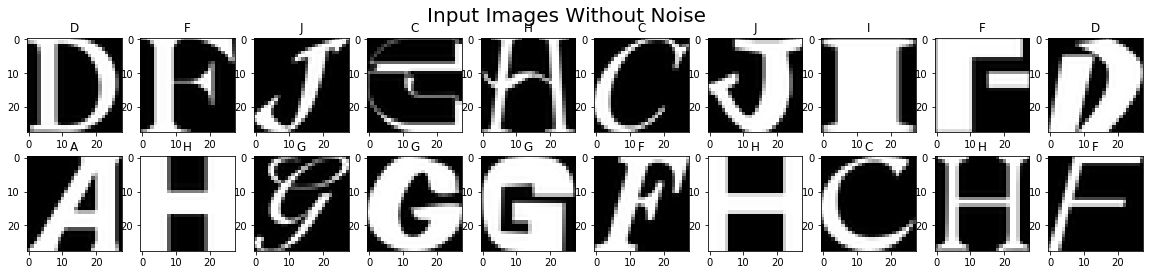

In [69]:
plt.figure(figsize=(20, 4))
print("Test Images Without Noise")
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title(str(label_dict[curr_lbl]))
plt.suptitle("Input Images Without Noise", fontsize = 20)
plt.show()    

Test Images With Noise


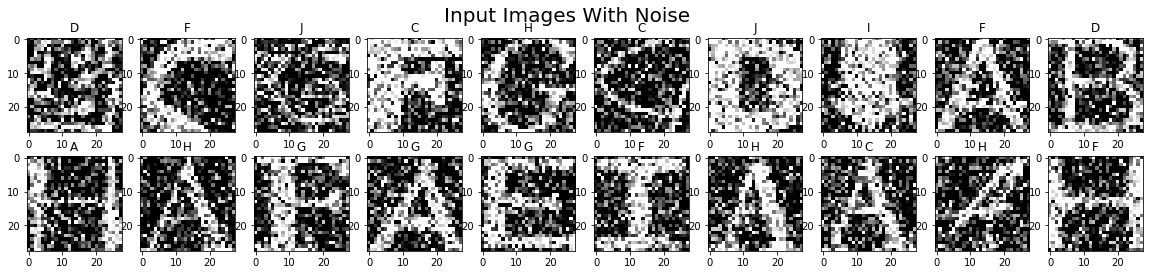

In [70]:
plt.figure(figsize=(20, 4))
print("Test Images With Noise")
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_train_noisy[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title(str(label_dict[curr_lbl]))
plt.suptitle("Input Images With Noise", fontsize = 20)
plt.show()


#### Encoded Image

Text(0.5, 0.98, 'Encoded Images')

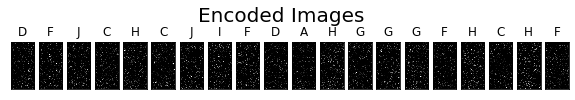

In [71]:
height = 112
width = 56
n = 20
plt.figure(figsize=(10, 3))
for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(encoded_preds[i].reshape((height,width)))
    plt.gray()
    curr_lbl = test_labels[i]
    plt.title(str(label_dict[curr_lbl]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Encoded Images", fontsize = 20)

#### Generated Image

Reconstruction of Test Images


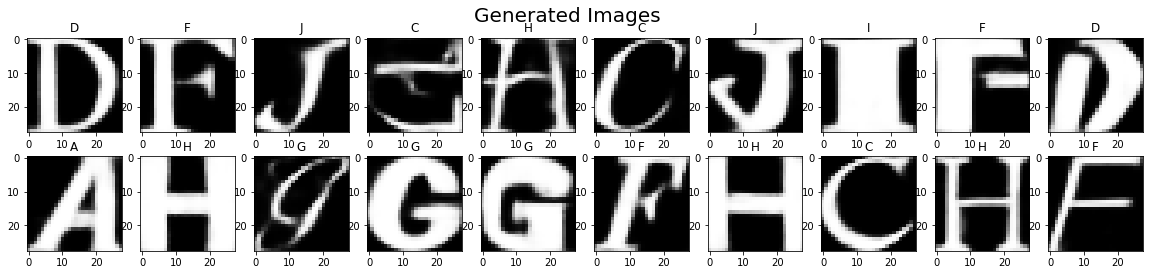

In [72]:
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(preds[i, ..., 0], cmap='gray')  
    curr_lbl = test_labels[i]
    plt.title(str(label_dict[curr_lbl]))
plt.suptitle("Generated Images", fontsize = 20)
plt.show()